In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
# from ltsfit.lts_linefit import lts_linefit
from astropy.table import Table, Column

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("BTFR_riz_distances_noCorrection.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

driz = df.set_index("PGC")

driz.head()

,DM_75,DMriz_fid,Mass_HI,Ms_riz,Mb,F21,eF21,Qs
PGC,,,,,,,,
4,33.717130,33.380425,1.376963e+09,1.632021e+09,3.463382e+09,1.905,0.07,5.0
16,34.298275,34.601422,1.469036e+09,1.630152e+10,1.825534e+10,1.190,0.20,5.0
55,33.894347,33.638481,3.659171e+09,1.529149e+09,6.395846e+09,4.300,0.32,5.0
68,34.993453,34.744737,3.770357e+09,9.308983e+09,1.432356e+10,1.610,0.27,5.0
70,34.709097,35.157406,1.501271e+10,2.862036e+10,4.858727e+10,8.330,0.12,5.0


In [4]:
df = pd.read_csv("BTFR_W1_distances_noCorrection.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

d1 = df.set_index("PGC")

d1.head()

,DM_75,DM1_fid,Mass_HI,Ms_W1,Mb,F21,eF21,Qw
PGC,,,,,,,,
2,34.110800,34.513882,4.913111e+09,8.939024e+10,9.592468e+10,4.730,0.81,5.0
4,33.717130,33.483647,1.376963e+09,1.323799e+09,3.155160e+09,1.905,0.07,4.0
12,34.613753,34.994547,5.612489e+09,2.968050e+10,3.714511e+10,3.400,0.58,5.0
16,34.298275,34.689486,1.469036e+09,1.535607e+10,1.730989e+10,1.190,0.20,5.0
55,33.894347,33.660640,3.659171e+09,1.382639e+09,6.249336e+09,4.300,0.32,4.0


In [5]:
df = driz.join(d1, how='outer', lsuffix='_riz', rsuffix='_w1')
commons = ['DM_75', 'Mass_HI', 'Mb', 'F21', 'eF21']
for col in commons:
    df[col] = df.apply(lambda X: X[col+"_riz"] if ~np.isnan(X[col+"_riz"]) else X[col+"_w1"], axis=1)


# df = df.join(dr[["r***", "DMr_fid", "logMs_r"]], how='left')
# df = df.join(di[["i***", "DMi_fid", "logMs_i"]], how='left')
# df = df.join(dz[["z***", "DMz_fid", "logMs_z"]], how='left')
    
# df = df[commons+["DMr_fid", "DMi_fid", "DMz_fid", "DMriz_fid", "DM1_fid", 
#                  "r***", 'i***', 'z***', 'w1***', "Qs", "Qw", "logMs_riz", 'logMs_W1']]

df.head()

,DM_75_riz,DMriz_fid,Mass_HI_riz,Ms_riz,Mb_riz,F21_riz,eF21_riz,Qs,DM_75_w1,DM1_fid,...,Ms_W1,Mb_w1,F21_w1,eF21_w1,Qw,DM_75,Mass_HI,Mb,F21,eF21
PGC,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.110800,34.513882,...,8.939024e+10,9.592468e+10,4.730,0.81,5.0,34.110800,4.913111e+09,9.592468e+10,4.730,0.81
4,33.717130,33.380425,1.376963e+09,1.632021e+09,3.463382e+09,1.905,0.07,5.0,33.717130,33.483647,...,1.323799e+09,3.155160e+09,1.905,0.07,4.0,33.717130,1.376963e+09,3.463382e+09,1.905,0.07
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.613753,34.994547,...,2.968050e+10,3.714511e+10,3.400,0.58,5.0,34.613753,5.612489e+09,3.714511e+10,3.400,0.58
16,34.298275,34.601422,1.469036e+09,1.630152e+10,1.825534e+10,1.190,0.20,5.0,34.298275,34.689486,...,1.535607e+10,1.730989e+10,1.190,0.20,5.0,34.298275,1.469036e+09,1.825534e+10,1.190,0.20
55,33.894347,33.638481,3.659171e+09,1.529149e+09,6.395846e+09,4.300,0.32,5.0,33.894347,33.660640,...,1.382639e+09,6.249336e+09,4.300,0.32,4.0,33.894347,3.659171e+09,6.395846e+09,4.300,0.32


In [6]:
old = pd.read_csv("../calibrators/DMs_EDD.csv.test", sep='|')

for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)
old = old.set_index("pgc")

# oldCols = ["P0", "ggg", "rrr", "iii", "zzz"]
# for col in oldCols:
#     old[col] = old[col].apply(lambda x: np.float(x))


df = df.join(old, how='left', lsuffix='_new', rsuffix='_old')

df.head()

,DM_75_riz,DMriz_fid,Mass_HI_riz,Ms_riz,Mb_riz,F21_riz,eF21_riz,Qs,DM_75_w1,DM1_fid,...,pgc1,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src
PGC,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.110800,34.513882,...,73150,200275,4976,0,7,341.4922,20.7395,2,2.02,2
4,33.717130,33.380425,1.376963e+09,1.632021e+09,3.463382e+09,1.905,0.07,5.0,33.717130,33.483647,...,120,202766,4154,0,0,316.0587,18.4514,2,-2.75,1
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.613753,34.994547,...,12,210177,6279,0,1,286.4249,11.3510,2,0.56,2
16,34.298275,34.601422,1.469036e+09,1.630152e+10,1.825534e+10,1.190,0.20,5.0,34.298275,34.689486,...,16,211419,5434,0,1,287.6120,11.7030,2,0.92,1
55,33.894347,33.638481,3.659171e+09,1.529149e+09,6.395846e+09,4.300,0.32,5.0,33.894347,33.660640,...,55,0,4507,0,0,327.0996,19.7763,2,-2.83,1


In [7]:
df.columns

Index([u'DM_75_riz', u'DMriz_fid', u'Mass_HI_riz', u'Ms_riz', u'Mb_riz',
       u'F21_riz', u'eF21_riz', u'Qs', u'DM_75_w1', u'DM1_fid', u'Mass_HI_w1',
       u'Ms_W1', u'Mb_w1', u'F21_w1', u'eF21_w1', u'Qw', u'DM_75', u'Mass_HI',
       u'Mb', u'F21', u'eF21', u'Vh', u'Vls', u'V3k', u'Vmod', u'f_cosmology',
       u'logWimx', u'logWimx_e', u'inc', u'Sqlt', u'Wqlt', u'DM_best',
       u'dDM_best', u'DMr', u'dDMr', u'RMS_r', u'DMr_raw', u'DMi', u'dDMi',
       u'RMS_i', u'DMi_raw', u'DMz', u'dDMz', u'RMS_z', u'DMz_raw', u'DM_w1',
       u'dDM_w1', u'RMS_w1', u'DMw1_raw', u'ggg', u'rrr', u'iii', u'zzz',
       u'w1', u'w2', u'RA', u'DEC', u'gl', u'gb', u'sgl', u'sgb', u'pgc1',
       u'Nest', u'Vmodg', u'Nkt', u'N15', u'sglg', u'sgbg', u'RS', u'P0',
       u'DM_src'],
      dtype='object')

In [8]:
len(df)

10154

In [9]:
df['logMs_riz'] = np.log10(df.Ms_riz)
df['logMs_W1'] = np.log10(df.Ms_W1)

In [10]:
import copy 

df_paper = copy.deepcopy(df)

# M_gas = 1.33 x M_HI = 1.33 x 2.36X10^5 x (3950/75)^2 x 69.07   => log Mgass = 10.78 not 7.851
df_paper['flag'] = 1
adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
df_paper.loc[adhi_list]['flag'] = 0

df_paper['DM_av'] = df_paper[['DMriz_fid', 'DM1_fid']].mean(axis=1)

indx = (df_paper.Qs<3) & (df_paper.Qw>=3)
df_paper['DM_av'][indx] = df_paper['DM1_fid'][indx]

indx = (df_paper.Qs>=3) & (df_paper.Qw<3)
df_paper['DM_av'][indx] = df_paper['DMriz_fid'][indx]

df_paper['Dav'] = 10**((df_paper.DM_av-25)/5.)

df_paper['DM_75'] = df_paper[['DM_75_riz', 'DM_75_w1']].mean(axis=1)
df_paper['D75'] = 10**((df_paper.DM_75-25)/5.)

df_paper['logMs'] = df_paper[['logMs_riz', 'logMs_W1']].mean(axis=1)
df_paper['Ms'] = 10**df_paper.logMs

df_paper['Mass_HI'] = 2.356E5 * df_paper.F21 * (df_paper.D75**2)

df_paper['logMgas'] = np.log10(1.33*(10**(np.log10(df_paper.Mass_HI))))
df_paper['Mgas'] = 1.33*(10**(np.log10(df_paper.Mass_HI)))

df_paper['Mb'] = df_paper.Ms+df_paper.Mgas
df_paper['logMb'] = np.log10(df_paper.Mb)



old = pd.read_csv("../calibrators/corrected_mags_linewidth_all.csv", sep='|')
for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)

old = old.set_index("pgc")

df_paper = df_paper.join(old[['inc_e']], how='left')


df_paper["DMriz_err"] = np.sqrt((0.017*(df_paper['logWimx']-2.5))**2 + (3.250*df_paper['logWimx_e'])**2 + 0.038**2 + 0.05**2)/0.4 + 0*df["DMriz_fid"]
df_paper["DM1_err"] = np.sqrt((0.027*(df_paper['logWimx']-2.5))**2 + (3.316*df_paper['logWimx_e'])**2 + 0.030**2 + 0.05**2)/0.4 + 0*df["DM1_fid"]


cols = ["flag", "DM_75", "DM_av", "DMriz_fid", "DMriz_err", "DM1_fid", "DM1_err"]
cols += ['pgc1', 'Nest']
cols += ['logMs_riz', 'logMs_W1']
cols += ['logMgas', 'logMb']
cols += ['Vh', 'Vls', 'V3k', 'Vmod', 'f_cosmology']
cols += ['logWimx', 'logWimx_e', 'F21', 'eF21', 'inc', 'inc_e']
cols += ['ggg', 'rrr', 'iii', 'zzz', 'w1']
cols += ['Qs', 'Qw']
cols += ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'Nkt', 'N15', 'sglg', 'sgbg', 'Vmodg']

df_paper = df_paper[cols]


# df_paper = df_paper.rename(columns={"V3k_old":"V3k"})
# df_paper = df_paper.rename(columns={"Vmod_old":"Vmod"})

df_paper.ggg[df_paper.ggg.astype(np.float64)<=0]=-1000000
df_paper.rrr[df_paper.rrr.astype(np.float64)<=0]=-1000000
df_paper.iii[df_paper.iii.astype(np.float64)<=0]=-1000000
df_paper.zzz[df_paper.zzz.astype(np.float64)<=0]=-1000000
df_paper.w1[df_paper.w1.astype(np.float64)<=0]=-1000000


df_paper.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPy

,flag,DM_75,DM_av,DMriz_fid,DMriz_err,DM1_fid,DM1_err,pgc1,Nest,logMs_riz,...,DEC,gl,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.110800,34.513882,NaN,NaN,34.513882,0.281635,73150,200275,NaN,...,47.2745,113.9553,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976
4,1,33.717130,33.432036,33.380425,0.194329,33.483647,0.187512,120,202766,9.212726,...,23.0876,107.8322,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154
12,1,34.613753,34.994547,NaN,NaN,34.994547,0.227175,12,210177,NaN,...,-6.3739,90.1920,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279
16,1,34.298275,34.645454,34.601422,0.256730,34.689486,0.253384,16,211419,10.212228,...,-5.1587,91.6005,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434
55,1,33.894347,33.649561,33.638481,0.256932,33.660640,0.253900,55,0,9.184450,...,33.6009,110.9496,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507


In [11]:
df_paper.loc.__setitem__((90661, ('DM1_fid')), np.nan)
df_paper.loc.__setitem__((90661, ('DM1_err')), np.nan)

df_paper.loc.__setitem__((90661, ('DM_av')), df_paper.loc[90661]['DMriz_fid'])

# df_paper.loc[90661]

In [12]:
tfr4 = pd.read_csv("EDD_CF4_TF.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    tfr4.rename(columns={col:newcol}, inplace=True)

tfr4 = tfr4.set_index("PGC")
tfr4 = tfr4[["PGC1", "Nest"]]

df_paper = df_paper.join(tfr4, how='left', lsuffix='_new', rsuffix='_old')

In [13]:
df_paper.head()

,flag,DM_75,DM_av,DMriz_fid,DMriz_err,DM1_fid,DM1_err,pgc1,Nest_new,logMs_riz,...,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg,PGC1,Nest_old
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.110800,34.513882,NaN,NaN,34.513882,0.281635,73150,200275,NaN,...,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976,73150.0,200275.0
4,1,33.717130,33.432036,33.380425,0.194329,33.483647,0.187512,120,202766,9.212726,...,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154,120.0,202766.0
12,1,34.613753,34.994547,NaN,NaN,34.994547,0.227175,12,210177,NaN,...,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279,12.0,210177.0
16,1,34.298275,34.645454,34.601422,0.256730,34.689486,0.253384,16,211419,10.212228,...,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434,16.0,211419.0
55,1,33.894347,33.649561,33.638481,0.256932,33.660640,0.253900,55,0,9.184450,...,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507,55.0,0.0


In [14]:
df_paper = df_paper.reset_index()

In [15]:
df_paper['pgc1_'] = df_paper.apply(lambda X: X.PGC1 if X.PGC1>0 else X.pgc1, axis=1)
df_paper['Nest_'] = df_paper.apply(lambda X: X.Nest_old if X.Nest_old>0 else X.Nest_new, axis=1)

In [16]:
df_paper['pgc1'] = df_paper['pgc1_']
df_paper['Nest_new'] = df_paper['Nest_']

df_paper = df_paper.drop(["Nest_old", "PGC1"], axis=1)
df_paper = df_paper.drop(["pgc1_", "Nest_"], axis=1)

df_paper = df_paper.rename(columns={"pgc1":"PGC1"})
df_paper = df_paper.rename(columns={"Nest_new":"Nest"})

df_paper.Nest[df_paper.Nest.astype(np.float64)<=0]=-1000000
df_paper.PGC1[df_paper.PGC1.astype(np.float64)<=0]=-1000000

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [17]:
flags = pd.read_csv("BTFR_flags.csv", sep='|')
flags = flags[['PGC', 'flag']]
flags = flags.set_index('PGC')

try:
    df_paper = df_paper.set_index('PGC')
except:
    pass



df_paper = df_paper.join(flags, how='left', lsuffix='_l', rsuffix='_r')

df_paper['flag_l'] = df_paper['flag_r']
df_paper = df_paper.rename(columns={"flag_l":"flag"})
df_paper = df_paper.drop(columns=['flag_r'])

df_paper['flag'][((df_paper.DMriz_err>0.8) | (df_paper.DM1_err>0.8))] = 0

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
df_paper.columns

Index([u'flag', u'DM_75', u'DM_av', u'DMriz_fid', u'DMriz_err', u'DM1_fid',
       u'DM1_err', u'PGC1', u'Nest', u'logMs_riz', u'logMs_W1', u'logMgas',
       u'logMb', u'Vh', u'Vls', u'V3k', u'Vmod', u'f_cosmology', u'logWimx',
       u'logWimx_e', u'F21', u'eF21', u'inc', u'inc_e', u'ggg', u'rrr', u'iii',
       u'zzz', u'w1', u'Qs', u'Qw', u'RA', u'DEC', u'gl', u'gb', u'sgl',
       u'sgb', u'Nkt', u'N15', u'sglg', u'sgbg', u'Vmodg'],
      dtype='object')

In [19]:
len(df_paper)

10154

In [20]:
df_brent = pd.read_csv("btfr_brent_updated.csv", sep='|')
for col in df_brent.columns:
    newcol = col.strip()
    df_brent.rename(columns={col:newcol}, inplace=True)
df_brent = df_brent.set_index("PGC")
df_brent = df_brent[['Vhel', 'Vls', 'v3k', 'f', 'Vhg', 'Vlsg', 'V3kg', 'fg']]

df_paper_ = df_paper.join(df_brent, how='inner', lsuffix='_org', rsuffix='_brt')

df_paper_['f_cosmology'] = df_paper_.f
df_paper_['Vh'] = df_paper_.Vhel
df_paper_['Vls_org'] = df_paper_.Vls_brt
df_paper_['V3k'] = df_paper_.v3k


df_paper_ = df_paper_.drop(["f", "Vhel", "Vls_brt", "v3k","Vmodg","Vmod"], axis=1)
df_paper_ = df_paper_.rename(columns={"Vls_org":"Vls"})


df_paper_ = df_paper_.reset_index()

df_paper_.to_csv('BTFR_CF4_Dist_bar.NO.csv', sep='|', index=False)

print(df_paper_.columns)

len(df_paper_)

Index([u'PGC', u'flag', u'DM_75', u'DM_av', u'DMriz_fid', u'DMriz_err',
       u'DM1_fid', u'DM1_err', u'PGC1', u'Nest', u'logMs_riz', u'logMs_W1',
       u'logMgas', u'logMb', u'Vh', u'Vls', u'V3k', u'f_cosmology', u'logWimx',
       u'logWimx_e', u'F21', u'eF21', u'inc', u'inc_e', u'ggg', u'rrr', u'iii',
       u'zzz', u'w1', u'Qs', u'Qw', u'RA', u'DEC', u'gl', u'gb', u'sgl',
       u'sgb', u'Nkt', u'N15', u'sglg', u'sgbg', u'Vhg', u'Vlsg', u'V3kg',
       u'fg'],
      dtype='object')


10154

In [21]:
table   = np.genfromtxt('BTFR_CF4_Dist_bar.NO.csv' , delimiter='|', 
                        filling_values=-1000000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
    if key in ["pgc", "PGC"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ["f_cosmology",'logMs_riz','logMs_W1','logMgas','logMb','logWimx','logWimx_e', 'fg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))    
    elif key in ["Vh", "Vls", 'V3k', 'Vmod', 'Vmodg', 'inc', 
                 'Qs', 'Qw', 'Nkt', 'N15', '1PGC', 'Nest', 'flag', 'Vhg', 'Vlsg', 'V3kg']:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
    elif key in ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'sglg', 'sgbg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.4f'))      
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.2f'))

## to be used on EDD
myTable.write('BTFR_CF4_Dist_bar.NO', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

# For paper Submission


In [22]:
table   = np.genfromtxt('BTFR_CF4_Dist_bar.NO.csv' , delimiter='|', 
                        filling_values=-1000000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
  if not key in ["DM_75", "Vhg", "Vlsg"]:

    if key in ["pgc", "PGC"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ["f",'logMs_riz','logMs_W1','logMgas','logMb','logWimx','logWimx_e', 'fg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))    
    elif key in ["Vh", "Vls", 'V3k', 'Vmod', 'Vmodg', 'inc', 
                 'Qs', 'Qw', 'Nkt', 'N15', '1PGC', 'Nest', 'flag', 'Vhg', 'Vlsg', 'V3kg']:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
    elif key in ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'sglg', 'sgbg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.4f'))      
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.2f'))

## to be used on EDD
## Also good for the paper submission
myTable.write('table1_paper.NO.csv', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

In [23]:
df_test = pd.read_csv("table1_paper.NO.csv", sep='|')

df_test[df_test.columns[30:]].head()

,RA,DEC,gl,gb,sgl,sgb,Nkt,N15,sglg,sgbg,V3kg,fg
0,0.0005,47.2745,113.9553,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4916,1.013
1,0.0010,23.0876,107.8322,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4109,1.011
2,0.0024,-6.3739,90.1920,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6179,1.016
3,0.0031,-5.1587,91.6005,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5354,1.014
4,0.0104,33.6009,110.9496,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4454,1.012


In [24]:
def strzjg(number, decimal=2, num2=None):
    dec = str(decimal)
    number = np.float64(number)
    s = ''
    if number==-1000000 and num2 is None:
        return ''
    if np.float64(num2)==-1000000:
        return ''
    if num2 is not None:
        s = '$\pm$'
    if decimal==0:
        return s+'%d'%number
    format = '%0.'+dec+'f'
    return s + format%number
    
myTable.columns

<TableColumns names=('PGC','flag','DM_av','DMriz_fid','DMriz_err','DM1_fid','DM1_err','PGC1','Nest','logMs_riz','logMs_W1','logMgas','logMb','Vh','Vls','V3k','f_cosmology','logWimx','logWimx_e','F21','eF21','inc','inc_e','ggg','rrr','iii','zzz','w1','Qs','Qw','RA','DEC','gl','gb','sgl','sgb','Nkt','N15','sglg','sgbg','V3kg','fg')>

In [25]:
myTable

PGC,flag,DM_av,DMriz_fid,DMriz_err,DM1_fid,DM1_err,PGC1,Nest,logMs_riz,logMs_W1,logMgas,logMb,Vh,Vls,V3k,f_cosmology,logWimx,logWimx_e,F21,eF21,inc,inc_e,ggg,rrr,iii,zzz,w1,Qs,Qw,RA,DEC,gl,gb,sgl,sgb,Nkt,N15,sglg,sgbg,V3kg,fg
int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,float64
2,1,34.51,-1000000.00,-1000000.00,34.51,0.28,73150.00,200275,-1000000.000,10.951,9.815,10.982,5004,5296,4726,1.01,2.744,0.029,4.73,0.81,52,4.00,-1000000.00,-1000000.00,-1000000.00,-1000000.00,11.89,-1000000,5,0.0005,47.2745,113.9553,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4916,1.013
4,1,33.43,33.38,0.19,33.48,0.19,120.00,202766,9.213,9.122,9.263,9.519,4458,4706,4109,1.01,2.189,0.014,1.91,0.07,85,2.00,15.59,15.33,15.12,15.07,16.07,5,4,0.0010,23.0876,107.8322,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4109,1.011
12,1,34.99,-1000000.00,-1000000.00,34.99,0.23,12.00,210177,-1000000.000,10.472,9.873,10.570,6548,6685,6195,1.02,2.606,0.021,3.40,0.58,82,3.00,-1000000.00,-1000000.00,-1000000.00,-1000000.00,13.59,-1000000,5,0.0024,-6.3739,90.1920,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6179,1.016
16,1,34.65,34.60,0.26,34.69,0.25,16.00,211419,10.212,10.186,9.291,10.250,5667,5809,5312,1.01,2.515,0.025,1.19,0.20,65,4.00,14.36,13.86,13.58,13.40,13.99,5,5,0.0031,-5.1587,91.6005,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5354,1.014
55,1,33.65,33.64,0.26,33.66,0.25,55.00,-1000000,9.184,9.141,9.687,9.801,4779,5052,4454,1.01,2.260,0.025,4.30,0.32,80,3.00,15.53,15.32,15.22,15.17,16.20,5,4,0.0104,33.6009,110.9496,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4454,1.012
68,1,34.66,34.74,0.38,34.58,0.39,68.00,-1000000,9.969,10.048,9.700,10.182,7664,7740,7338,1.02,2.390,0.043,1.61,0.27,57,4.00,14.93,14.61,14.52,14.34,15.03,5,5,0.0154,-18.9589,65.4189,-75.8101,274.3903,7.1770,0,0,274.3903,7.1770,7338,1.019
70,1,35.11,35.16,0.16,35.06,0.15,70.00,209949,10.457,10.531,10.300,10.709,6800,7040,6447,1.02,2.636,0.005,8.33,0.12,90,1.00,13.87,13.46,13.24,13.02,13.54,5,5,0.0156,20.3380,107.1780,-40.9837,313.2487,17.7662,0,1,313.2488,17.7663,6450,1.017
76,1,34.73,34.66,0.19,34.80,0.18,76.00,209247,10.708,10.670,10.041,10.777,6920,7183,6583,1.02,2.624,0.013,4.42,0.11,68,4.00,13.80,13.21,12.91,12.73,13.23,5,5,0.0164,28.9115,109.8058,-32.6709,322.1726,19.1316,0,1,322.1729,19.1316,6566,1.017
92,1,32.82,32.82,0.20,-1000000.00,-1000000.00,92.00,-1000000,9.450,-1000000.000,9.735,9.917,5376,5592,5015,1.01,2.165,0.016,3.78,0.08,80,3.00,15.64,15.30,15.09,14.94,-1000000.00,5,-1000000,0.0208,13.1125,104.5148,-47.9564,305.8667,16.2222,0,0,305.8667,16.2222,5015,1.013


In [26]:
for i in range(10):
    
    row = ''

    row += strzjg(myTable['PGC'][i], 0) + ' & '
    
    row += strzjg(myTable['flag'][i], 0) + ' & '
    row += strzjg(myTable['DM_av'][i], 2) + ' & '
    row += strzjg(myTable['DMriz_fid'][i], 2) + strzjg(myTable['DMriz_err'][i], 2, num2=myTable['DMriz_fid'][i]) + ' & '
    row += strzjg(myTable['DM1_fid'][i], 2) + strzjg(myTable['DM1_err'][i], 2, num2=myTable['DM1_fid'][i]) + ' & '
    row += strzjg(myTable['PGC1'][i], 0) + ' & '
    row += strzjg(myTable['Nest'][i], 0) + ' & '
    row += strzjg(myTable['logMs_riz'][i], 3) + ' & '
    row += strzjg(myTable['logMs_W1'][i], 3)  + ' & '
    
    row += strzjg(myTable['logMgas'][i], 3)  + ' & '
    row += strzjg(myTable['logMb'][i], 3)  + ' & '
    row += strzjg(myTable['Vh'][i], 0)  + ' & '
    row += strzjg(myTable['Vls'][i], 0)  + ' & '
    row += strzjg(myTable['V3k'][i], 0)  + ' & '
#     row += strzjg(myTable['Vmod'][i], 0)  + ' & '
    row += strzjg(myTable['f_cosmology'][i], 3) + ' & '
    
    row += strzjg(myTable['logWimx'][i], 3) + '$\pm$' + strzjg(myTable['logWimx_e'][i], 3) + ' & '
      
#     row += strzjg(myTable[''][i], 2)  + ' & '
    

    print(row+' \\\\')

2 & 1 & 34.51 &  & 34.51$\pm$0.28 & 73150 & 200275 &  & 10.951 & 9.815 & 10.982 & 5004 & 5296 & 4726 & 1.013 & 2.744$\pm$0.029 &  \\
4 & 1 & 33.43 & 33.38$\pm$0.19 & 33.48$\pm$0.19 & 120 & 202766 & 9.213 & 9.122 & 9.263 & 9.519 & 4458 & 4706 & 4109 & 1.011 & 2.189$\pm$0.014 &  \\
12 & 1 & 34.99 &  & 34.99$\pm$0.23 & 12 & 210177 &  & 10.472 & 9.873 & 10.570 & 6548 & 6685 & 6195 & 1.016 & 2.606$\pm$0.021 &  \\
16 & 1 & 34.65 & 34.60$\pm$0.26 & 34.69$\pm$0.25 & 16 & 211419 & 10.212 & 10.186 & 9.291 & 10.250 & 5667 & 5809 & 5312 & 1.014 & 2.515$\pm$0.025 &  \\
55 & 1 & 33.65 & 33.64$\pm$0.26 & 33.66$\pm$0.25 & 55 &  & 9.184 & 9.141 & 9.687 & 9.801 & 4779 & 5052 & 4454 & 1.012 & 2.260$\pm$0.025 &  \\
68 & 1 & 34.66 & 34.74$\pm$0.38 & 34.58$\pm$0.39 & 68 &  & 9.969 & 10.048 & 9.700 & 10.182 & 7664 & 7740 & 7338 & 1.019 & 2.390$\pm$0.043 &  \\
70 & 1 & 35.11 & 35.16$\pm$0.16 & 35.06$\pm$0.15 & 70 & 209949 & 10.457 & 10.531 & 10.300 & 10.709 & 6800 & 7040 & 6447 & 1.017 & 2.636$\pm$0.005 &  \\

In [27]:
myTable.columns

<TableColumns names=('PGC','flag','DM_av','DMriz_fid','DMriz_err','DM1_fid','DM1_err','PGC1','Nest','logMs_riz','logMs_W1','logMgas','logMb','Vh','Vls','V3k','f_cosmology','logWimx','logWimx_e','F21','eF21','inc','inc_e','ggg','rrr','iii','zzz','w1','Qs','Qw','RA','DEC','gl','gb','sgl','sgb','Nkt','N15','sglg','sgbg','V3kg','fg')>

In [28]:
for i in range(10):
    
    row = ''

    row += strzjg(myTable['PGC'][i], 0) + ' & '
    
    row += strzjg(myTable['F21'][i], 2) + '$\pm$' + strzjg(myTable['eF21'][i], 2) + ' & '
    row += strzjg(myTable['inc'][i], 0)  + strzjg(myTable['inc_e'][i], 0, num2=myTable['inc'][i]) + ' & '
    row += strzjg(myTable['ggg'][i], 2)  + ' & '
    row += strzjg(myTable['rrr'][i], 2)  + ' & '
    row += strzjg(myTable['iii'][i], 2)  + ' & '
    row += strzjg(myTable['zzz'][i], 2)  + ' & '
    row += strzjg(myTable['w1'][i], 2)   + ' & '
    row += strzjg(myTable['Qs'][i], 0)   + ' & '
    row += strzjg(myTable['Qw'][i], 0)   + ' & '
    row += strzjg(myTable['RA'][i], 4)   + ' & '
    row += strzjg(myTable['DEC'][i], 4)  + ' & '
    row += strzjg(myTable['gl'][i], 4)   + ' & '
    row += strzjg(myTable['gb'][i], 4)   + ' & '
    row += strzjg(myTable['sgl'][i], 4)  + ' & '
    row += strzjg(myTable['sgb'][i], 4)  + ' & '
    row += strzjg(myTable['Nkt'][i], 0)  + ' & '
    row += strzjg(myTable['N15'][i], 0)  + ' & '
    row += strzjg(myTable['sglg'][i], 4) + ' & '
    row += strzjg(myTable['sgbg'][i], 4) + ' & '
#     row += strzjg(myTable['Vhg'][i], 0)  + ' & '
#     row += strzjg(myTable['Vlsg'][i], 0) + ' & ' 
    row += strzjg(myTable['V3kg'][i], 0) + ' & '
    row += strzjg(myTable['fg'][i], 3)   
    
#     row += strzjg(myTable['Vmodg'][i], 0) 

    print(row+' \\\\')

2 & 4.73$\pm$0.81 & 52$\pm$4 &  &  &  &  & 11.89 &  & 5 & 0.0005 & 47.2745 & 113.9553 & -14.6992 & 341.6440 & 20.7388 & 0 & 7 & 341.4922 & 20.7395 & 4916 & 1.013 \\
4 & 1.91$\pm$0.07 & 85$\pm$2 & 15.59 & 15.33 & 15.12 & 15.07 & 16.07 & 5 & 4 & 0.0010 & 23.0876 & 107.8322 & -38.2729 & 316.0587 & 18.4514 & 0 & 0 & 316.0587 & 18.4514 & 4109 & 1.011 \\
12 & 3.40$\pm$0.58 & 82$\pm$3 &  &  &  &  & 13.59 &  & 5 & 0.0024 & -6.3739 & 90.1920 & -65.9300 & 286.4249 & 11.3511 & 0 & 1 & 286.4249 & 11.3510 & 6179 & 1.016 \\
16 & 1.19$\pm$0.20 & 65$\pm$4 & 14.36 & 13.86 & 13.58 & 13.40 & 13.99 & 5 & 5 & 0.0031 & -5.1587 & 91.6005 & -64.8656 & 287.6119 & 11.7030 & 0 & 1 & 287.6120 & 11.7030 & 5354 & 1.014 \\
55 & 4.30$\pm$0.32 & 80$\pm$3 & 15.53 & 15.32 & 15.22 & 15.17 & 16.20 & 5 & 4 & 0.0104 & 33.6009 & 110.9496 & -28.0857 & 327.0996 & 19.7763 & 0 & 0 & 327.0996 & 19.7763 & 4454 & 1.012 \\
68 & 1.61$\pm$0.27 & 57$\pm$4 & 14.93 & 14.61 & 14.52 & 14.34 & 15.03 & 5 & 5 & 0.0154 & -18.9589 & 65.4189 & -

In [29]:
df_paper = df_paper[df_paper.flag==1]
try: 
    df_paper = df_paper.set_index('PGC')
except:
    pass

print(len(df_paper))
df_paper.head()

10024


,flag,DM_75,DM_av,DMriz_fid,DMriz_err,DM1_fid,DM1_err,PGC1,Nest,logMs_riz,...,DEC,gl,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.110800,34.513882,NaN,NaN,34.513882,0.281635,73150.0,200275.0,NaN,...,47.2745,113.9553,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976
4,1,33.717130,33.432036,33.380425,0.194329,33.483647,0.187512,120.0,202766.0,9.212726,...,23.0876,107.8322,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154
12,1,34.613753,34.994547,NaN,NaN,34.994547,0.227175,12.0,210177.0,NaN,...,-6.3739,90.1920,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279
16,1,34.298275,34.645454,34.601422,0.256730,34.689486,0.253384,16.0,211419.0,10.212228,...,-5.1587,91.6005,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434
55,1,33.894347,33.649561,33.638481,0.256932,33.660640,0.253900,55.0,-1000000.0,9.184450,...,33.6009,110.9496,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507


In [30]:
cf3 = pd.read_csv("../calibrators/cf3.csv", sep='|')

for col in cf3.columns:
    newcol = col.strip()
    cf3.rename(columns={col:newcol}, inplace=True)

cf3.set_index('PGC', inplace=True)

cf3['DM_cf3'] = cf3['DM']
cf3 = cf3[['DM_cf3']]

df34 = df_paper.join(cf3, how='inner')

# df = copy.deepcopy(df_paper)

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
def constant(x,delta):
    return delta

(array([-0.13742741]), array([[3.19125745e-05]]))
(-0.11955399896613272, 0.2918221894797231)


Text(2500,-2,'$\\Delta =-0.120\\pm0.292$ [mag]')

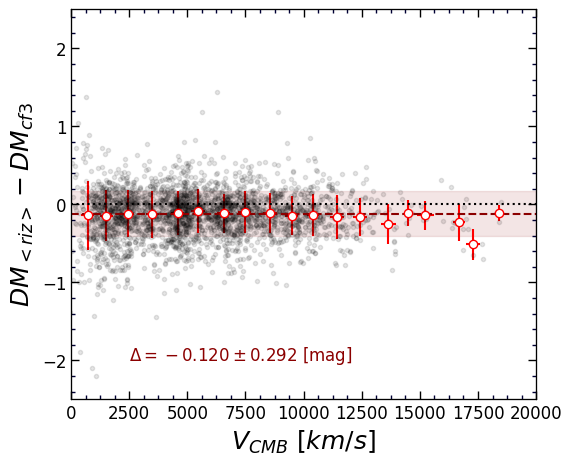

In [32]:
dff = df34[df34.Qs>2]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.DMriz_fid.values-dff.DM_cf3.values

Ye = np.sqrt(dff.DMriz_err.values**2+0.4**2)

fit, cov = curve_fit(constant, X, Y, sigma=Ye)
print(fit, cov)

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y-med)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -2, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

(array([-0.01338127]), array([[1.14221412e-05]]))
(-0.013381267881557671, 0.13098909788724344)


Text(2500,-0.6,'$\\Delta =-0.013\\pm0.131$ [mag]')

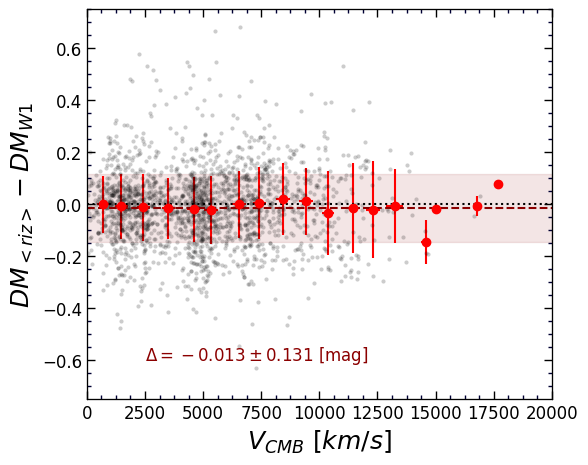

In [33]:
dff = df_paper[(df_paper.Qs>2)&(df_paper.Qw>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.DMriz_fid.values-dff.DM1_fid.values
Ye = np.sqrt(dff.DMriz_err.values**2+dff.DM1_err.values**2)

fit, cov = curve_fit(constant, X, Y, sigma=Ye)
print(fit, cov)

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.40]
Y = Y[np.abs(Y)<0.40]


for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{W1}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-.75,.75), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = fit[0] #np.median(Y)
std = np.std(Y-fit[0])
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -0.6, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

(-0.08011599913004552, 0.30977828288514503)


Text(2500,-2,'$\\Delta =-0.080\\pm0.310$ [mag]')

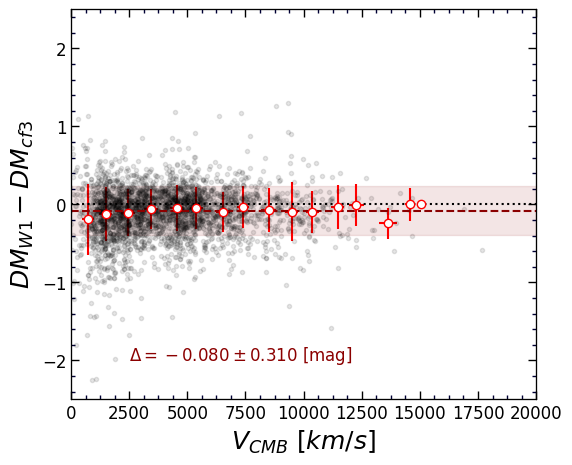

In [34]:
dff = df34[(df34.Qw>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.DM1_fid.values-dff.DM_cf3.values

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,16000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{W1}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y-med)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -2, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

In [35]:
# from astropy.table import Table, Column

# df_ = df.reset_index()

# df_.to_csv('BTFR_CF4_Dist_bar.csv', sep='|', index=False)


# table   = np.genfromtxt('BTFR_CF4_Dist_bar.csv' , delimiter='|', 
#                         filling_values=-100000, names=True, dtype=None, encoding=None)

# colnames = table.dtype.names

# ## table is a structured array
# myTable = {}
# for name in table.dtype.names:
#     myTable[name] = table[name]
# table = myTable
# ## table is now a dictionary

# myTable = Table()

# for key in colnames:
#     if key in ["PGC"]:
#         myTable.add_column(Column(data=table[key], name=key))
#     elif key in ["F21", "eF21", "lgWmxi", "elgWi"]:
#         myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))    
#     elif key in ["Vls", 'V3k', 'Vmod', "Qs", "Qw"]:
#         myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
#     elif key in ["P0", "ggg", "rrr", "iii", "zzz"]:
#         pass
#     else:
#         myTable.add_column(Column(data=table[key], name=key, format='%0.2f'))

# ## to be used on EDD
# myTable.write('BTFR_CF4_Dist_bar', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)
# ## cf4btfdistances

In [36]:
# fig = py.figure(figsize=(5,4), dpi=100)    
# fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
# ax = fig.add_subplot(111)

# bins = np.arange(1.4,3,0.1)

# ax.hist(df_[df_.Qs>0].lgWmxi, bins=bins, alpha=0.5, density=True, label='optical (Qs>0)')
# ax.hist(df_[df_.Qw>0].lgWmxi, bins=bins, alpha=1, density=True, histtype='step', color='red', label='Infrared (Qw>0)')

# ax.legend(loc=2)

# ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=14)
# ax.set_ylabel('Normalized Count', fontsize=14)

# set_axes(ax, (1.3,3), (0,2.2), fontsize=12)


In [37]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [44]:
def myHubble(D, H0):
    return H0    


def plotHubble(ax, X, Y, Ye, band="", color='red'):
       
    ax.plot(X, 10**Y, 'k.', alpha=0.05, mec='white', ms=5)
    
#     m = np.median(Y[X>4000])
#     e1 = np.std(Y[X>4000])/np.sqrt(len(Y[X>4000])) 
#     e2 = m/np.sqrt(len(Y[X>4000])) 
#     e = np.sqrt(e1**2)
#     H0e_fit = 10**m*e*np.log(10)    
    
    for i in np.arange(0,18000, 1000):
        xp = []
        yp = []
        ype  = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+1000 and Y[ii]>-10000: #and Ye[ii]>0:
                xp.append(xi)
                yp.append(Y[ii])
                ype.append(Ye[ii])
        if len(xp)>2:
            yp = np.asarray(yp)
            ype = np.asarray(ype)
            
            fit, cov = curve_fit(myHubble, xp, yp, sigma=ype)
            yy = fit[0]
            e = np.sqrt(cov[0])
            H0e_fit = (10**yy)*np.log(10.)*np.sqrt(cov[0])
            H0 = 10**yy  
    
            if np.median(xp)>4000:
                ax.errorbar(i+500, 10**yy, yerr=H0e_fit, xerr=np.std(xp), fmt='o', 
                        color=color, ms=5, capsize=2)     
            else:
                ax.errorbar(i+500, 10**yy, yerr=H0e_fit, xerr=np.std(xp), fmt='o', 
                        color=color, ms=5, capsize=2)  
            

    
    fit, cov = curve_fit(myHubble, X[X>4000], Y[X>4000], sigma=Ye[X>4000])
    yy = fit[0]
    sigma = np.std(Y[X>4000]-yy)
    
    
    ind = ((X>4000)&(np.abs(Y-yy)<3.5*sigma))
    fit, cov = curve_fit(myHubble, X[ind], Y[ind], sigma=Ye[ind])
    yy = fit[0]
    H0e_fit = (10**yy)*np.log(10.)*np.sqrt(cov[0])
    H0 = 10**yy  

    ax.plot([4000,20000], [H0, H0], '--', color='blue')

    x_ax, y_ax = set_axes(ax, (0,20000), (35,150), fontsize=14) 

    ax.set_yscale('log')

    from matplotlib.ticker import MultipleLocator

    from matplotlib.ticker import NullFormatter
    
    ax.set_yticks(np.arange(30,150, step=30))
    ax.yaxis.set_major_formatter(NullFormatter())  
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))


    y_ax.set_yticks(np.arange(30,150, step=30))
    y_ax.set_yscale('log')
    y_ax.yaxis.set_major_formatter(NullFormatter())  
    y_ax.yaxis.set_minor_formatter(NullFormatter())
    y_ax.yaxis.set_major_locator(MultipleLocator(30))
    y_ax.yaxis.set_minor_locator(MultipleLocator(10))


    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.80*Xlm[0]+0.20*Xlm[1]
    y0 = 0.95*Ylm[0]+0.05*Ylm[1] 
    unit= '   km/s/Mpc'
    ax.text(x0,y0, r"$ \langle H_0 \rangle_{"+band+"}= $"+"%.1f" % H0+'$\pm$'+"%.1f" % H0e_fit+unit, fontsize=14, 
            color='blue', backgroundcolor='white')

    ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(3,3))



In [45]:
df_paper.columns

Index([u'flag', u'DM_75', u'DM_av', u'DMriz_fid', u'DMriz_err', u'DM1_fid',
       u'DM1_err', u'PGC1', u'Nest', u'logMs_riz', u'logMs_W1', u'logMgas',
       u'logMb', u'Vh', u'Vls', u'V3k', u'Vmod', u'f_cosmology', u'logWimx',
       u'logWimx_e', u'F21', u'eF21', u'inc', u'inc_e', u'ggg', u'rrr', u'iii',
       u'zzz', u'w1', u'Qs', u'Qw', u'RA', u'DEC', u'gl', u'gb', u'sgl',
       u'sgb', u'Nkt', u'N15', u'sglg', u'sgbg', u'Vmodg'],
      dtype='object')

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10
/media/Data/Hom

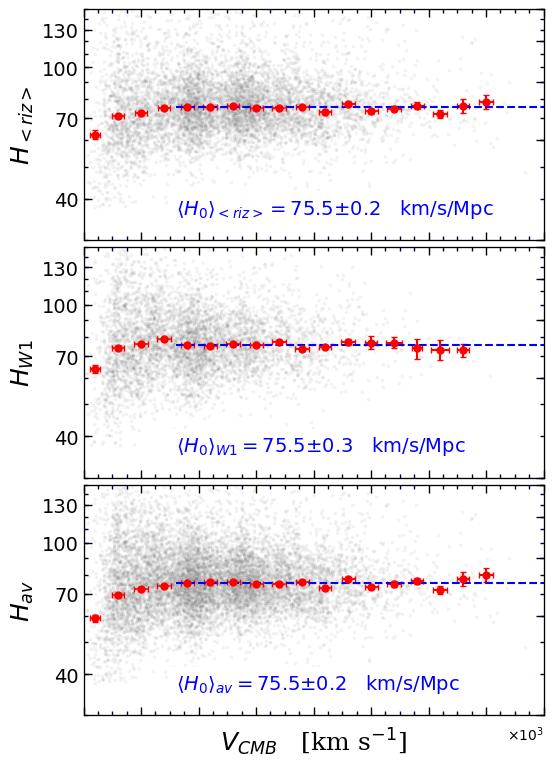

In [46]:
fig = py.figure(figsize=(5, 11.8), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(4,1) ; p=0

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

####################################################
####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[(df_paper.Qs>2)&(df_paper.logWimx>0)]
X = dff.V3k.values
Y  = np.log10(dff.Vmod.values)-(dff.DMriz_fid.values-25)/5.
Ye = dff.DMriz_err.values/5.

Y0 = dff.Vmod.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DMriz_fid.values

ind, = np.where(np.abs(Y0)<1.5)

plotHubble(ax, X[ind], Y[ind], Ye[ind], band="<riz>")
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{<riz>}$', fontsize=18, fontdict=font) 
####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[(df_paper.Qw>2)&(df_paper.logWimx>0)]
X = dff.V3k.values
Y  = np.log10(dff.Vmod.values)-(dff.DM1_fid.values-25)/5.
Ye = dff.DM1_err.values/5.

Y0 = dff.Vmod.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DM1_fid.values

ind, = np.where(np.abs(Y0)<1.5)
plotHubble(ax, X[ind], Y[ind], Ye[ind], band="W1")
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{W1}$', fontsize=18, fontdict=font) 

####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[((df_paper.Qw>2)|(df_paper.Qs>2))&(df_paper.logWimx>0)]
X = dff.V3k.values
Y  = np.log10(dff.Vmod.values)-(dff.DM_av.values-25)/5.
Ye = dff[["DMriz_err", "DM1_fid"]].mean(axis=1).values/5.

Y0 = dff.Vmod.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DM_av.values

ind, = np.where(np.abs(Y0)<1.5)
plotHubble(ax, X[ind], Y[ind], Ye[ind], band="av")
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{av}$', fontsize=18, fontdict=font) 



ax.set_xlabel(r'$V_{CMB} $'+'   [km s'+r'$^{-1}$'+']', fontsize=18, fontdict=font) 


plt.subplots_adjust(hspace=0.03, wspace=0.2)

In [41]:
dff.columns

Index([u'flag', u'DM_75', u'DM_av', u'DMriz_fid', u'DMriz_err', u'DM1_fid',
       u'DM1_err', u'PGC1', u'Nest', u'logMs_riz', u'logMs_W1', u'logMgas',
       u'logMb', u'Vh', u'Vls', u'V3k', u'Vmod', u'f_cosmology', u'logWimx',
       u'logWimx_e', u'F21', u'eF21', u'inc', u'inc_e', u'ggg', u'rrr', u'iii',
       u'zzz', u'w1', u'Qs', u'Qw', u'RA', u'DEC', u'gl', u'gb', u'sgl',
       u'sgb', u'Nkt', u'N15', u'sglg', u'sgbg', u'Vmodg'],
      dtype='object')

In [42]:
df = pd.read_csv("simulation_dm.csv", sep=',')

df.head()

,Unnamed: 0,V,DM75,DM_fid,DM_cor
0,0,3963.793815,33.615249,33.845211,33.715230
1,1,9544.087287,35.523366,35.629182,35.524249
2,2,6478.835789,34.682179,34.142482,34.528580
3,3,2328.077976,32.459681,32.537878,32.435315
4,4,4743.064186,34.004989,33.900956,33.879217


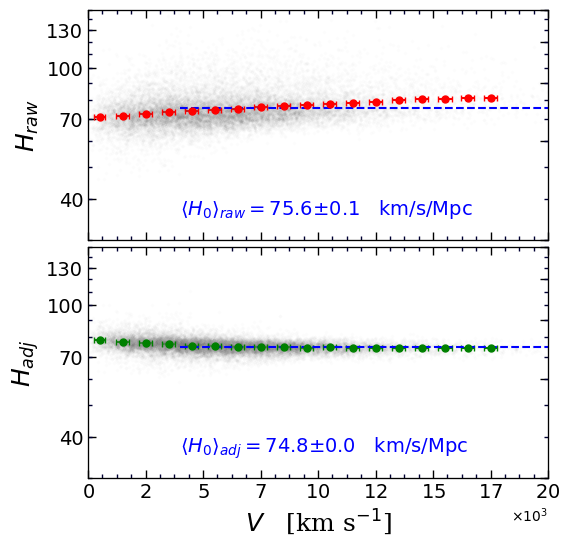

In [43]:
fig = py.figure(figsize=(5, 11.8), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(4,1) ; p=0

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


ax = plt.subplot(gs[p]) ; p+=1

X = df.V.values
Y  = np.log10(df.V.values)-(df.DM_fid.values-25)/5.
Ye = (df.DM_cor.values*0+0.05)/5.
plotHubble(ax, X, Y, Ye, band="raw")
ax.set_ylabel(r'$H_{raw}$', fontsize=18, fontdict=font) 

plt.setp(ax.get_xticklabels(), visible=False)

ax = plt.subplot(gs[p]) ; p+=1

X = df.V.values
Y  = np.log10(df.V.values)-(df.DM_cor.values-25)/5.
Ye = (df.DM_cor.values*0+0.05)/5.
plotHubble(ax, X, Y, Ye, band="adj", color='green')


ax.set_ylabel(r'$H_{adj}$', fontsize=18, fontdict=font) 



ax.set_xlabel(r'$V$'+'   [km s'+r'$^{-1}$'+']', fontsize=18, fontdict=font) 


plt.subplots_adjust(hspace=0.03, wspace=0.2)